In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import heapq
import wandb
# plt.switch_backend('agg')
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 30

In [3]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.char2index = {}
        self.char2count = {}
        self.index2char = {0: "SOS", 1: "EOS"}
        self.n_chars = 2  # Count SOS and EOS

    def addWord(self, word):
        for char in word:
            self.addChar(char)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [4]:
def readLangs(lang, type, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    
    lines = open('aksharantar_sampled/%s/%s_%s.csv' % (lang, lang, type), encoding='utf-8').read().strip().split('\n')
    
    # Split every line into pairs and normalize
    # pairs = [[normalizeString(s) for s in l.split(',')] for l in lines]
    pairs = [[s for s in l.split(',')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang)
        output_lang = Lang('eng')
    else:
        input_lang = Lang('eng')
        output_lang = Lang(lang)

    return input_lang, output_lang, pairs

In [5]:
def prepareData(lang, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang, reverse)
    print("Read %s word pairs" % len(pairs))
    print("Trimmed to %s word pairs" % len(pairs))
    print("Counting chars...")
    for pair in pairs:
        input_lang.addWord(pair[0])
        output_lang.addWord(pair[1])
    print("Counted chars:")
    print(input_lang.name, input_lang.n_chars)
    print(output_lang.name, output_lang.n_chars)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('mni', 'train')
print(random.choice(pairs))

Reading lines...
Read 10060 word pairs
Trimmed to 10060 word pairs
Counting chars...
Counted chars:
eng 28
mni 46
['langli', 'ꯂꯥꯡꯂꯤ']


In [6]:
cells = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}

In [7]:
class EncoderRNN(nn.Module):
    """
    Class for the encoder RNN.
    """
    def __init__(self, input_size, embedding_size, hidden_size, num_hidden_layers, dropout=0.2, cell_type='gru'):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_hidden_layers = num_hidden_layers
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.cell_type = cell_type
        self.cell = cells[cell_type](embedding_size, hidden_size, num_hidden_layers, dropout=dropout)

    def forward(self, input, hidden, cell=None):
        embedded = self.embedding(input).view(1, 1, -1)
        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            output, hidden = self.cell(embedded, hidden)
            return output, hidden
        else:
            output, (hidden, cell) = self.cell(embedded, (hidden, cell))    
            return output, hidden, cell

    def initHidden(self):
        return torch.zeros(self.num_hidden_layers, 1, self.hidden_size, device=device)

In [8]:
class BeamSearchNode:
    def __init__(self, decoder_output, hidden, prev_node, char_idx, log_prob, length):
        self.decoder_output = decoder_output
        self.hidden = hidden
        self.prev_node = prev_node
        self.char_idx = char_idx
        self.log_prob = log_prob
        self.length = length

    # def __lt__(self, other):
    #     return self.log_prob > other.log_prob

    def eval(self):
        return self.log_prob / self.length

In [9]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding_size, output_size, num_hidden_layers, dropout=0.1, cell_type='gru', max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.cell_type = cell_type
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.embedding_size)
        self.attn = nn.Linear(self.embedding_size + self.hidden_size, self.max_length)
        self.attn_combine = nn.Linear(self.embedding_size + self.hidden_size, self.hidden_size)
        self.cell = cells[cell_type](self.hidden_size, self.hidden_size, self.num_hidden_layers, dropout=self.dropout)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs, cell=None):
        embedded = self.embedding(input).view(1, 1, -1)
        # embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)

        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            output, hidden = self.cell(output, hidden)
        else:
            output, (hidden, cell) = self.cell(output, (hidden, cell))

        output = F.log_softmax(self.out(output[0]), dim=1)

        if self.cell_type == 'rnn' or self.cell_type == 'gru':
            return output, hidden, attn_weights
        else:
            return output, hidden, cell, attn_weights

    def initHidden(self):
        return torch.zeros(self.num_hidden_layers, 1, self.hidden_size, device=device)

In [10]:
def indexesFromWord(lang, word):
    return [lang.char2index[char] for char in word]


def tensorFromWord(lang, word):
    indexes = indexesFromWord(lang, word)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromWord(input_lang, pair[0])
    target_tensor = tensorFromWord(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [11]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, beam_width=1, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    if encoder.cell_type == 'lstm':
        encoder_cell = encoder.initHidden()
        
    loss = 0

    # assert False, print(encoder_outputs.shape, max_length)
    for ei in range(input_length):
        if encoder.cell_type == 'lstm':
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        else:
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # assert False, print(encoder_output.shape)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_hidden = encoder_hidden

    decoder_input = torch.tensor([[SOS_token]], device=device)

    if decoder.cell_type == 'lstm':
        decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            if decoder.cell_type == 'lstm':
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, decoder_cell)
            else:
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            if decoder.cell_type == 'lstm':
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, decoder_cell)
            else:
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
                
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [12]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
def trainIters(encoder, decoder, n_iters, optimizer=optim.SGD, cell_type='gru', beam_width=1, print_every=1000, learning_rate=5e-3):
    start = time.time()
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optimizer(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optimizer(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for _ in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, cell_type, encoder_optimizer, decoder_optimizer, criterion, beam_width)
        print_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters), iter, iter / n_iters * 100, print_loss_avg))

In [14]:
def evaluate(encoder, decoder, word, beam_width=1, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromWord(input_lang, word)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        if encoder.cell_type == 'lstm':
            encoder_cell = encoder.initHidden()

        for ei in range(input_length):
            if encoder.cell_type == 'lstm':
                encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            else:
                encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)

            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_hidden = encoder_hidden

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        if decoder.cell_type == 'lstm':
            decoder_cell = encoder_cell

        decoded_chars = ""
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            if decoder.cell_type == 'lstm':
                decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs, decoder_cell)
            else:
                decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_chars += '<EOS>'
                break
            else:
                decoded_chars += output_lang.index2char[topi.item()]

            decoder_input = topi.squeeze().detach()

        return decoded_chars, decoder_attentions[:di + 1]

In [15]:
input_valid_lang, output_valid_lang, valid_pairs = prepareData('mni', 'valid')
input_test_lang, output_test_lang, test_pairs = prepareData('mni', 'test')

def evalAccuracy(encoder, decoder, pairs):
    correct = 0
    for pair in pairs:
        # pair = pairs[i]
        output_word, _ = evaluate(encoder, decoder, pair[0])
        if output_word[-5:] == '<EOS>':
            output_word = output_word[:-5]
        # output_word = 
        # print(pair, output_word)
        # assert False
        if output_word == pair[1]:
            correct += 1
    return correct / len(pairs)

Reading lines...
Read 3260 word pairs
Trimmed to 3260 word pairs
Counting chars...
Counted chars:
eng 28
mni 46
Reading lines...
Read 4096 word pairs
Trimmed to 4096 word pairs
Counting chars...
Counted chars:
eng 28
mni 46


In [16]:
def trainBatch(encoder, decoder, epochs, optimizer=optim.SGD, beam_width=1, print_every=1000, learning_rate=5e-3, log=False):
    start = time.time()
    print_loss_total = 0  # Reset every print_every

    encoder_optimizer = optimizer(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optimizer(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(pair) for pair in pairs]
    criterion = nn.NLLLoss()

    # print("Training pairs:", len(training_pairs))

    for iter in range(1, len(training_pairs) * epochs + 1):
        training_pair = training_pairs[(iter - 1) % len(training_pairs)]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, beam_width)
        print_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / (len(training_pairs) * epochs)), iter, iter / (len(training_pairs) * epochs) * 100, print_loss_avg))

        if log:
            wandb.log({"train_loss": loss})

            if iter % len(training_pairs) == 0:
                wandb.log({"train_accuracy": evalAccuracy(encoder, decoder, pairs), "val_accuracy": evalAccuracy(encoder, decoder, valid_pairs), "epoch": iter / len(training_pairs)})

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        # output_chars, attentions = evaluate(encoder, decoder, pair[0])
        output_word, _ = evaluate(encoder, decoder, pair[0])
        # output_word = ''.join(output_chars)

        if output_word[-5:] == '<EOS>':
            output_word = output_word[:-5]
        print('<', output_word)
        print('')

In [24]:
hidden_size = 256
# embedding_size = input_lang.n_chars
embedding_size = 128
encoder1 = EncoderRNN(input_lang.n_chars, embedding_size, hidden_size, num_hidden_layers=1, cell_type='lstm', dropout=0.2).to(device)
decoder1 = AttnDecoderRNN(hidden_size, embedding_size, output_lang.n_chars, num_hidden_layers=1, cell_type='lstm', dropout=0.2).to(device)

/home/abdullah/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [25]:
# trainIters(encoder1, decoder1, n_iters=1, beam_width=5, print_every=100)

In [26]:
trainBatch(encoder1, decoder1, epochs=2, beam_width=1, print_every=100)

0m 2s (- 6m 41s) (100 0%) 3.1604
0m 3s (- 5m 25s) (200 0%) 2.4187
0m 4s (- 4m 59s) (300 1%) 2.4328
0m 5s (- 4m 51s) (400 1%) 2.9096
0m 7s (- 4m 56s) (500 2%) 3.0395
0m 9s (- 4m 59s) (600 2%) 2.7820
0m 10s (- 5m 1s) (700 3%) 2.9280
0m 12s (- 5m 2s) (800 3%) 2.9090
0m 14s (- 5m 5s) (900 4%) 2.7745
0m 16s (- 5m 8s) (1000 4%) 2.7361
0m 17s (- 5m 8s) (1100 5%) 2.7386
0m 19s (- 5m 7s) (1200 5%) 2.5955
0m 21s (- 5m 6s) (1300 6%) 2.7240
0m 22s (- 5m 4s) (1400 6%) 2.7213
0m 24s (- 5m 2s) (1500 7%) 2.5944
0m 25s (- 5m 0s) (1600 7%) 2.6140
0m 27s (- 4m 58s) (1700 8%) 2.7647
0m 29s (- 4m 56s) (1800 8%) 2.6870
0m 30s (- 4m 55s) (1900 9%) 2.5481
0m 32s (- 4m 53s) (2000 9%) 2.5446
0m 34s (- 4m 52s) (2100 10%) 2.6291
0m 35s (- 4m 51s) (2200 10%) 2.7064
0m 37s (- 4m 49s) (2300 11%) 2.6034
0m 39s (- 4m 48s) (2400 11%) 2.5691
0m 40s (- 4m 47s) (2500 12%) 2.6373
0m 42s (- 4m 45s) (2600 12%) 2.7107
0m 44s (- 4m 44s) (2700 13%) 2.6765
0m 45s (- 4m 43s) (2800 13%) 2.6257
0m 47s (- 4m 41s) (2900 14%) 2.6317
0

In [1256]:
encoder2 = EncoderRNN(input_lang.n_chars, embedding_size, hidden_size, num_hidden_layers=2, cell_type='gru').to(device)
decoder2 = DecoderRNN(hidden_size, embedding_size, output_lang.n_chars, num_hidden_layers=2, cell_type='gru').to(device)

In [1257]:
trainBatch(encoder2, decoder2, epochs=4, beam_width=1, print_every=100)

0m 2s (- 16m 10s) (100 0%) 2.7145
0m 5s (- 17m 32s) (200 0%) 2.7649
0m 7s (- 17m 31s) (300 0%) 2.9577
0m 10s (- 17m 32s) (400 0%) 2.8226
0m 12s (- 17m 8s) (500 1%) 2.8124
0m 15s (- 16m 36s) (600 1%) 2.7360
0m 17s (- 16m 19s) (700 1%) 2.7871
0m 19s (- 16m 20s) (800 1%) 2.7793
0m 22s (- 16m 18s) (900 2%) 2.8150
0m 25s (- 16m 22s) (1000 2%) 2.8402
0m 27s (- 16m 33s) (1100 2%) 2.7464
0m 32s (- 17m 31s) (1200 2%) 2.6716
0m 36s (- 18m 1s) (1300 3%) 2.7219
0m 40s (- 18m 53s) (1400 3%) 2.6794
0m 44s (- 19m 16s) (1500 3%) 2.5827
0m 48s (- 19m 30s) (1600 3%) 2.6698
0m 53s (- 20m 9s) (1700 4%) 2.6470
0m 57s (- 20m 31s) (1800 4%) 2.6580
1m 1s (- 20m 45s) (1900 4%) 2.6411
1m 5s (- 20m 55s) (2000 4%) 2.6749
1m 10s (- 21m 12s) (2100 5%) 2.6077
1m 14s (- 21m 30s) (2200 5%) 2.6726
1m 19s (- 21m 45s) (2300 5%) 2.5735
1m 23s (- 21m 57s) (2400 5%) 2.5459
1m 28s (- 22m 9s) (2500 6%) 2.6169
1m 30s (- 21m 55s) (2600 6%) 2.6146
1m 35s (- 22m 10s) (2700 6%) 2.6166
1m 40s (- 22m 19s) (2800 6%) 2.5944
1m 44s (- 

In [27]:
evaluateRandomly(encoder1, decoder1)

> lainupaani
= ꯂꯥꯢꯅꯨꯄꯥꯅꯤ
< ꯂꯥꯢꯅꯨꯅꯥꯄꯤ<EOS>

> taraanipaan
= ꯇꯔꯥꯅꯤꯄꯥꯟ
< ꯄꯥꯔꯥꯟꯇꯅꯥꯟ<EOS>

> nangsu
= ꯅꯪꯁꯨ
< ꯅꯥꯡꯁꯨ<EOS>

> hakchaangsi
= ꯍꯛꯆꯥꯡꯁꯤ
< ꯆꯥꯛꯆꯥꯡꯒꯤ<EOS>

> sijinnarambaa
= ꯁꯤꯖꯤꯟꯅꯔꯝꯕꯥ
< ꯁꯤꯟꯅꯔꯥꯃꯥꯕꯕ<EOS>

> leikhut
= ꯂꯩꯈꯨꯠ
< ꯂꯩꯈꯨꯨ<EOS>

> amukkhak
= ꯑꯃꯨꯛꯈꯛ
< ꯑꯃꯨꯛꯛꯈ<EOS>

> toreirol
= ꯇꯣꯔꯩꯔꯣꯜ
< ꯇꯣꯔꯔꯣꯤꯌꯦ<EOS>

> lapthoknaba
= ꯂꯥꯞꯊꯣꯛꯅꯕ
< ꯂꯥꯟꯊꯣꯛꯇꯕ<EOS>

> numitsibu
= ꯅꯨꯃꯤꯠꯁꯤꯕꯨ
< ꯅꯨꯝꯤꯤꯤꯌꯝꯕ<EOS>



In [1142]:
# pair = random.choice(pairs)

# print(pair[0])
# print(pair[1])

# with torch.no_grad():
#     input_tensor = tensorFromWord(input_lang, pair[0])
#     input_length = input_tensor.size()[0]
#     encoder1_hidden = encoder1.initHidden()

#     encoder1_outputs = torch.zeros(MAX_LENGTH, encoder1.hidden_size, device=device)

#     if encoder1.cell_type == 'lstm':
#         encoder1_cell = encoder1.initHidden()

#     for ei in range(input_length):
#         if encoder1.cell_type == 'lstm':
#             encoder1_output, encoder1_hidden, encoder1_cell = encoder1(input_tensor[ei], encoder1_hidden, encoder1_cell)
#         else:
#             encoder1_output, encoder1_hidden = encoder1(input_tensor[ei], encoder1_hidden)
            
#         encoder1_outputs[ei] += encoder1_output[0, 0]

#     decoder1_hidden = encoder1_hidden

#     if encoder1.cell_type == 'lstm':
#         decoder1_cell = encoder1_cell

#     decoded_chars = ""

#     # Predict the output using beam search
#     predicted_seq = decoder1.beam_search(encoder1_outputs, decoder1_hidden, 5, SOS_token, EOS_token)

#     # Convert the predicted sequence to a word
#     for char_idx in predicted_seq:
#         decoded_chars += output_lang.index2char[char_idx]

#     print(decoded_chars)

    



In [28]:
evalAccuracy(encoder1, decoder1, valid_pairs)

0.2067484662576687

In [1266]:
evalAccuracy(encoder2, decoder2, valid_pairs)

0.55

In [18]:
sweep_configuration = {
    'method': 'bayes',
    'name': 'bayes-sweep',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5, 10] 
        },
        'embedding_size': {
            'values': [64, 128, 256] 
        },
        'num_hidden_layers': {
            'values': [1, 2, 3]
        },
        'hidden_layer_size': {
            'values': [64, 128, 256] 
        },
        'cell_type': {
            'values': ['rnn', 'gru', 'lstm'] 
        },
        'learning_rate': {
            'values': [1e-2, 5e-3, 1e-3, 5e-4] 
        },
        'optimizer': {
            'values': ['SGD', 'Adam'] 
        },
        'dropout': {
            'values': [0.0, 0.2, 0.3] 
        },
        'beam_width': {
            'values': [1] #[1, 3, 5]
        }
    }
}


In [19]:
def hyperparameter_search():
    run = wandb.init(project='hyperparam-search-enc-dec-att', reinit=True)
    config = wandb.config
    wandb.run.name = f'hl_{config.num_hidden_layers}_sz_{config.hidden_layer_size}_ct_{config.cell_type}_lr_{config.learning_rate}_opt_{config.optimizer}_do_{config.dropout}_bw_{config.beam_width}_em_{config.embedding_size}'
    
    encoder = EncoderRNN(input_lang.n_chars, config.embedding_size, config.hidden_layer_size, config.num_hidden_layers, dropout=config.dropout, cell_type=config.cell_type).to(device)
    decoder = AttnDecoderRNN(config.hidden_layer_size, config.embedding_size, output_lang.n_chars, config.num_hidden_layers, dropout=config.dropout, cell_type=config.cell_type).to(device)

    if config.optimizer == 'SGD':
        optimizer = optim.SGD
    elif config.optimizer == 'Adam':
        optimizer = optim.Adam

    trainBatch(encoder, decoder, config.epochs, optimizer=optimizer, beam_width=config.beam_width, print_every=100, learning_rate=config.learning_rate, log=True)
    run.finish()

In [ ]:
sweep_id = wandb.sweep(sweep_configuration, project='hyperparam-search-seq2seq-att')
wandb.agent(sweep_id, hyperparameter_search, count=20)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: ssrbykfw
Sweep URL: https://wandb.ai/abdullah_010/hyperparam-search-seq2seq-att/sweeps/ssrbykfw


wandb: Ctrl + C detected. Stopping sweep.ed)


wandb: | 0.046 MB of 0.046 MB uploaded (0.000 MB deduped)
wandb: Run history:
wandb:          epoch ▁▂▃▃▄▅▆▆▇█
wandb: train_accuracy ▁▃▅▆▆▇▇▇▇█
wandb:     train_loss ▃▂▃▇█▁▁▆▁▁▁▁▁▁▂▅▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▂▂▃▁
wandb:   val_accuracy ▁▄▆▇▇█▇▇▇█
wandb: 
wandb: Run summary:
wandb:          epoch 10.0
wandb: train_accuracy 0.83429
wandb:     train_loss 0.01719
wandb:   val_accuracy 0.74387
wandb: 
wandb: 🚀 View run confused-sweep-19 at: https://wandb.ai/abdullah_010/hyperparam-search-seq2seq/runs/shvg5z2h
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20230518_103626-shvg5z2h/logs
wandb: Agent Starting Run: u07agu4e with config:
wandb: Agent Starting Run: 6arxitmf with config:
wandb: 	beam_width: 1
wandb: 	cell_type: gru
wandb: 	beam_width: 1
wandb: 	dropout: 0.3
wandb: 	cell_type: rnn
wandb: 	embedding_size: 128
wandb: 	dropout: 0
wandb: 	epochs: 10
wandb: 	embedding_size: 256
wandb: 	hidden_layer_size: 64
wandb: 	epochs: 

Thread WriterThread:
Traceback (most recent call last):
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 49, in run
    self._run()
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/internal/internal_util.py", line 100, in _run
    self._process(record)
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/internal/internal.py", line 381, in _process
    self._wm.write(record)
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/internal/writer.py", line 154, in write
    write_handler(record)
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/internal/writer.py", line 164, in write_request
    return write_request_handler(record)
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/internal/writer.py", line 182, in write_request_status_report
    self._write(record)
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/internal/writer.

Problem at: /tmp/ipykernel_9718/3525891295.py 2 hyperparameter_search


Traceback (most recent call last):
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 1144, in init
    run = wi.init()
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 787, in init
    run._on_init()
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/wandb_run.py", line 2135, in _on_init
    version_result = version_handle.wait(timeout=30)
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/lib/mailbox.py", line 281, in wait
    raise MailboxError("transport failed")
wandb.sdk.lib.mailbox.MailboxError: transport failed
wandb: ERROR Abnormal program exit
Exception in thread Thread-66 (_run_job):
Traceback (most recent call last):
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 1144, in init
    run = wi.init()
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 787, in init
    run._on_init()
 

Problem at: /tmp/ipykernel_9718/3525891295.py 2 hyperparameter_search


Traceback (most recent call last):
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 1144, in init
    run = wi.init()
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/wandb_init.py", line 744, in init
    result = run_init_handle.wait(
  File "/home/abdullah/.local/lib/python3.10/site-packages/wandb/sdk/lib/mailbox.py", line 281, in wait
    raise MailboxError("transport failed")
wandb.sdk.lib.mailbox.MailboxError: transport failed
wandb: ERROR Abnormal program exit


In [18]:
best_config = {'cell_type': 'gru', 'dropout': 0.2, 'embedding_size': 64, 'epochs': 10, 'hidden_layer_size': 128, 'learning_rate': 0.0005, 'num_hidden_layers': 1, 'optimizer': 'Adam', 'beam_width': 1}

encoder = EncoderRNN(input_lang.n_chars, best_config['embedding_size'], best_config['hidden_layer_size'], best_config['num_hidden_layers'], dropout=best_config['dropout'], cell_type=best_config['cell_type']).to(device)
decoder = AttnDecoderRNN(best_config['hidden_layer_size'], best_config['embedding_size'], output_lang.n_chars, best_config['num_hidden_layers'], dropout=best_config['dropout'], cell_type=best_config['cell_type']).to(device)

/home/abdullah/.local/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [32]:
optimizer = optim.SGD if best_config['optimizer'] == 'SGD' else optim.Adam

trainBatch(encoder, decoder, best_config['epochs'], optimizer=optimizer, beam_width=best_config['beam_width'], print_every=100, learning_rate=best_config['learning_rate'])

torch.save(encoder.state_dict(), 'attention_model/encoder.pt')
torch.save(decoder.state_dict(), 'attention_model/decoder.pt')


0m 1s (- 24m 31s) (100 0%) 2.7338
0m 2s (- 23m 21s) (200 0%) 2.8951
0m 4s (- 23m 26s) (300 0%) 2.8397
0m 5s (- 23m 14s) (400 0%) 2.5651
0m 6s (- 22m 50s) (500 0%) 2.5824
0m 8s (- 23m 13s) (600 0%) 2.4287
0m 9s (- 23m 5s) (700 0%) 2.3515
0m 11s (- 23m 3s) (800 0%) 2.1816
0m 12s (- 22m 55s) (900 0%) 2.1006
0m 13s (- 22m 34s) (1000 0%) 1.9235
0m 15s (- 22m 42s) (1100 1%) 1.9086
0m 16s (- 22m 50s) (1200 1%) 1.8401
0m 18s (- 22m 59s) (1300 1%) 1.7230
0m 19s (- 23m 3s) (1400 1%) 1.5928
0m 20s (- 23m 5s) (1500 1%) 1.5093
0m 22s (- 23m 6s) (1600 1%) 1.5042
0m 23s (- 23m 13s) (1700 1%) 1.4400
0m 25s (- 23m 13s) (1800 1%) 1.5743
0m 26s (- 23m 13s) (1900 1%) 1.4148
0m 28s (- 23m 12s) (2000 1%) 1.4032
0m 29s (- 23m 12s) (2100 2%) 1.3091
0m 31s (- 23m 17s) (2200 2%) 1.3174
0m 32s (- 23m 19s) (2300 2%) 1.2154
0m 34s (- 23m 21s) (2400 2%) 1.0848
0m 35s (- 23m 23s) (2500 2%) 1.2186
0m 37s (- 23m 22s) (2600 2%) 0.9615
0m 38s (- 23m 24s) (2700 2%) 1.0809
0m 40s (- 23m 22s) (2800 2%) 0.9172
0m 41s (- 23m

In [33]:
print(evalAccuracy(encoder, decoder, valid_pairs))
print(evalAccuracy(encoder, decoder, test_pairs))

0.7312883435582822
0.485595703125


In [19]:
encoder.load_state_dict(torch.load('attention_model/encoder.pt'))
decoder.load_state_dict(torch.load('attention_model/decoder.pt'))

<All keys matched successfully>

In [20]:
prediction_pairs = []

for pair in test_pairs:
    output_word, _ = evaluate(encoder, decoder, pair[0])
    if output_word[-5:] == '<EOS>':
        output_word = output_word[:-5]
    prediction_pairs.append((pair[0], output_word))

with open('predictions_attention/predictions.csv', 'w') as f:
    for pair in prediction_pairs:
        f.write(pair[0] + ',' + pair[1] + '\n')

In [20]:
evaluateRandomly(encoder, decoder)

> nongmangkha
= ꯅꯣꯡꯃꯥꯡꯈꯥ
< ꯅꯣꯡꯃꯥꯡꯈꯥ

> ninaa
= ꯅꯤꯅꯥ
< ꯅꯤꯅꯥ

> machaasinggi
= ꯃꯆꯥꯁꯤꯡꯒꯤ
< ꯃꯆꯥꯁꯤꯡꯒꯤ

> chahichaa
= ꯆꯍꯤꯆꯥ
< ꯆꯍꯤꯆꯥ

> pathaapsinggi
= ꯄꯊꯥꯞꯁꯤꯡꯒꯤ
< ꯄꯥꯊꯥꯤꯤꯡꯒꯤ

> bedaabati
= ꯕꯦꯗꯥꯕꯇꯤ
< ꯕꯦꯗꯥꯕꯇꯤ

> achoubaa
= ꯑꯆꯧꯕꯥ
< ꯑꯆꯧꯕꯥ

> puyaada
= ꯄꯨꯌꯥꯗ
< ꯄꯨꯌꯥꯗ

> phaoba
= ꯐꯥꯎꯕ
< ꯐꯥꯎꯕ

> sijinba
= ꯁꯤꯖꯤꯟꯕ
< ꯁꯤꯖꯤꯟꯕ



In [21]:
from pathlib import Path
import matplotlib as mpl

fpath = Path(mpl.get_data_path(), 'fonts/ttf/./NotoSansMeeteiMayek-Regular.ttf')


9 torch.Size([5, 30])


/tmp/ipykernel_19926/3488533202.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(input_word) + ['<EOS>'])
/tmp/ipykernel_19926/3488533202.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + list(output_word) + ['<EOS>'], font=fpath)


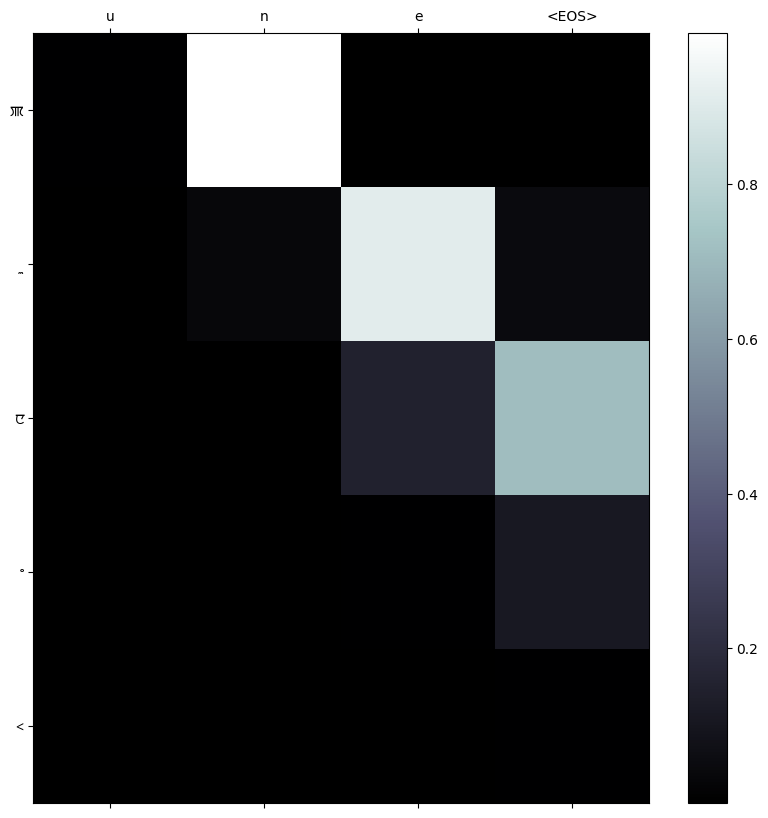

13 torch.Size([9, 30])


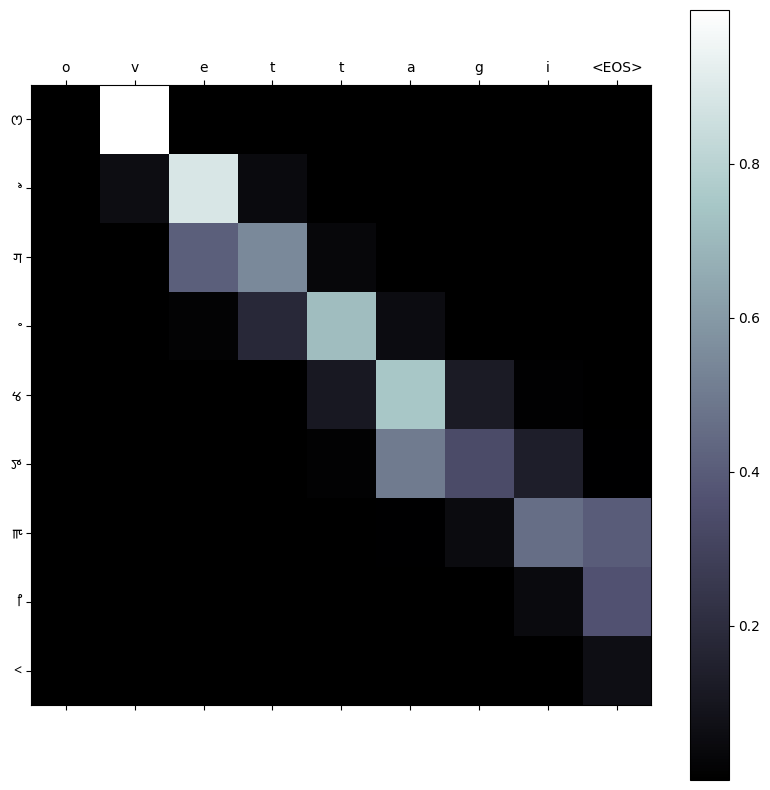

11 torch.Size([7, 30])


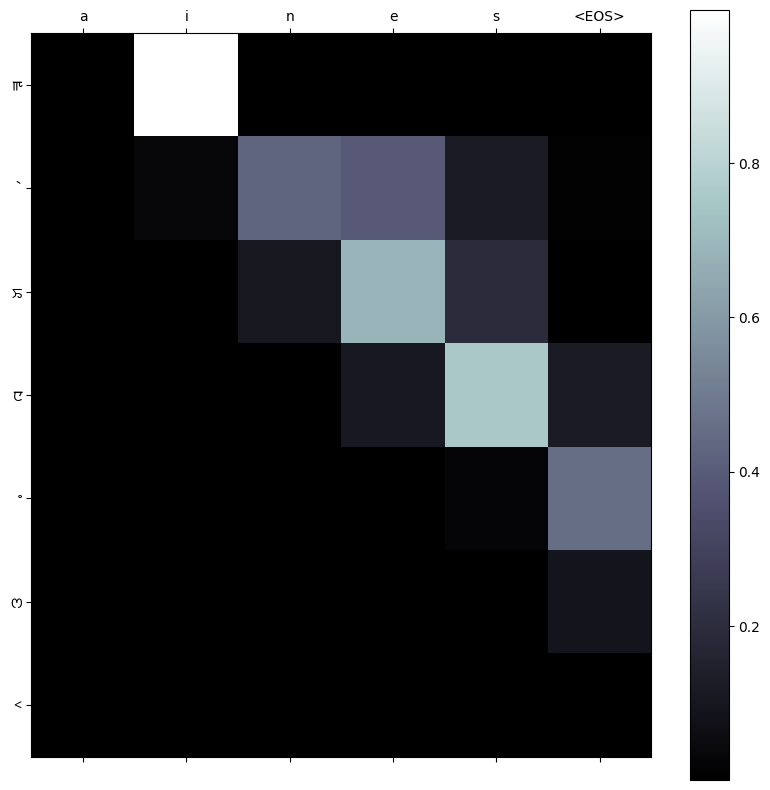

13 torch.Size([9, 30])


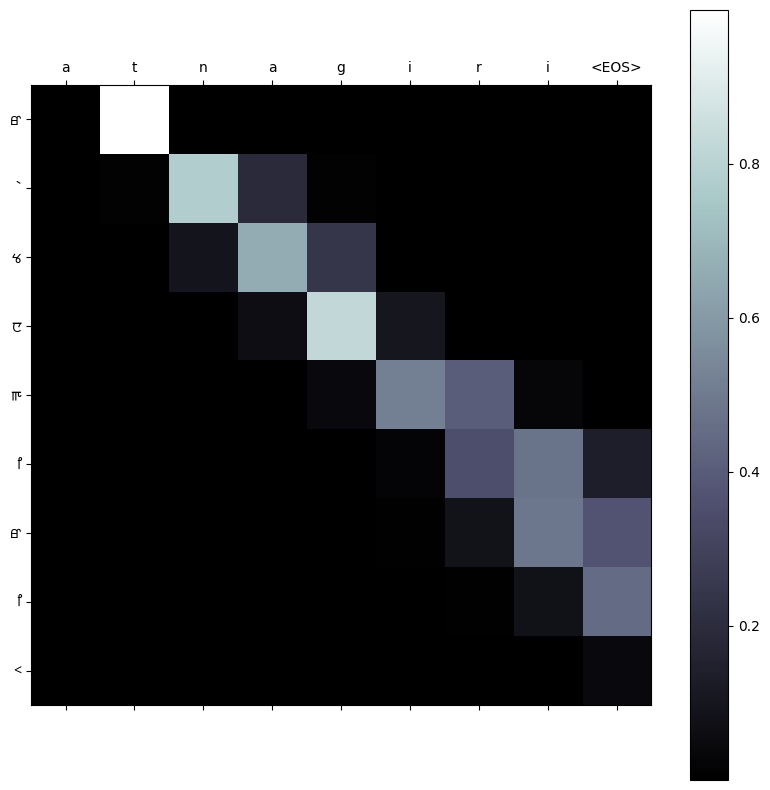

13 torch.Size([9, 30])


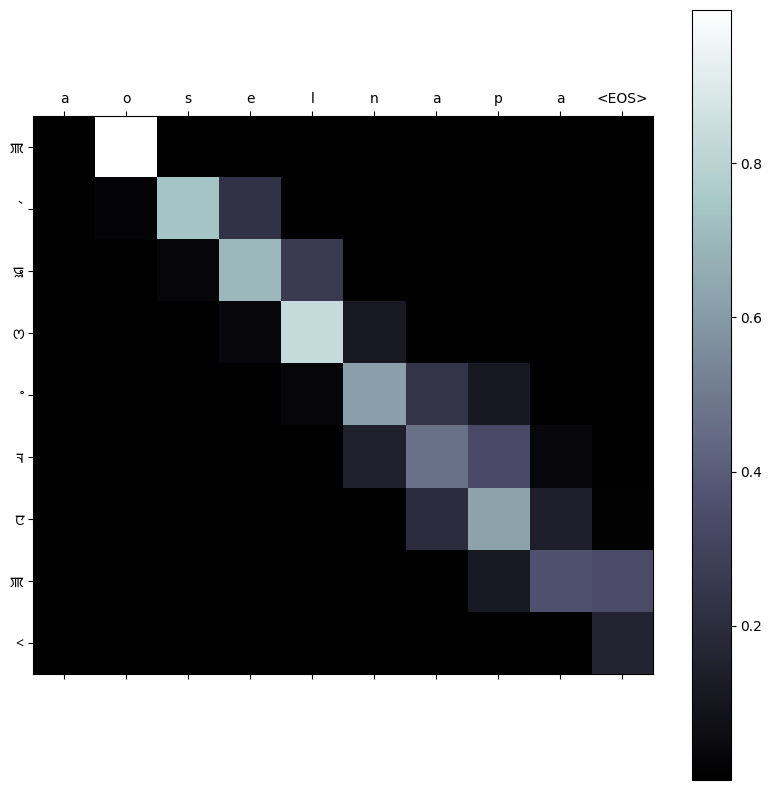

15 torch.Size([11, 30])


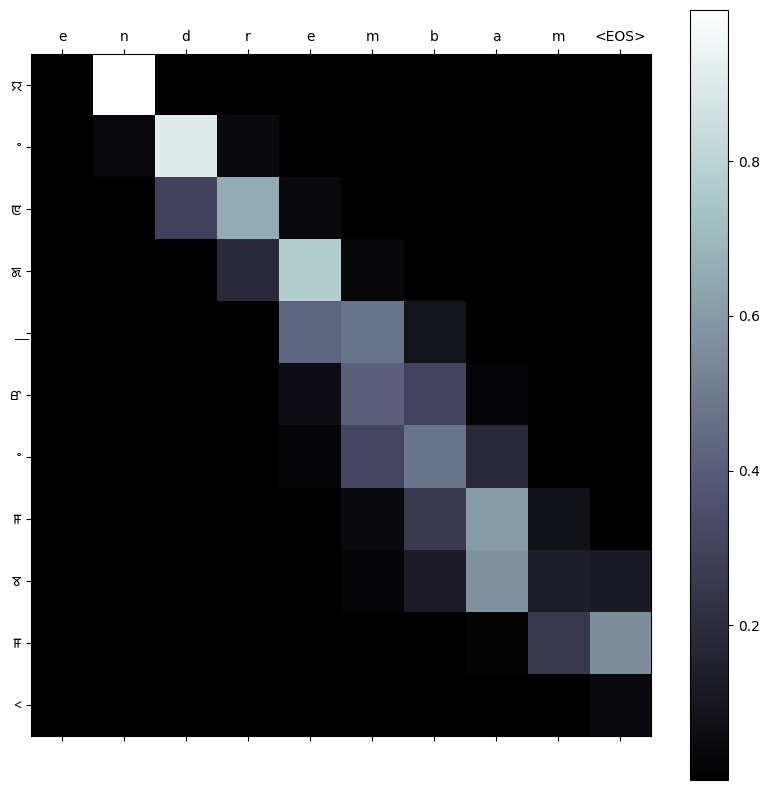

12 torch.Size([8, 30])


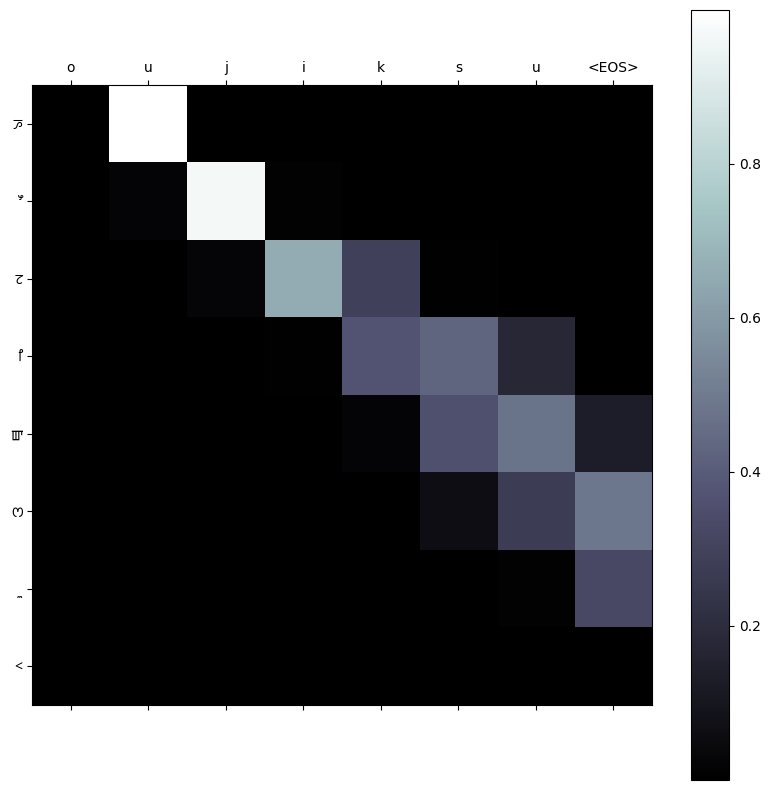

9 torch.Size([5, 30])


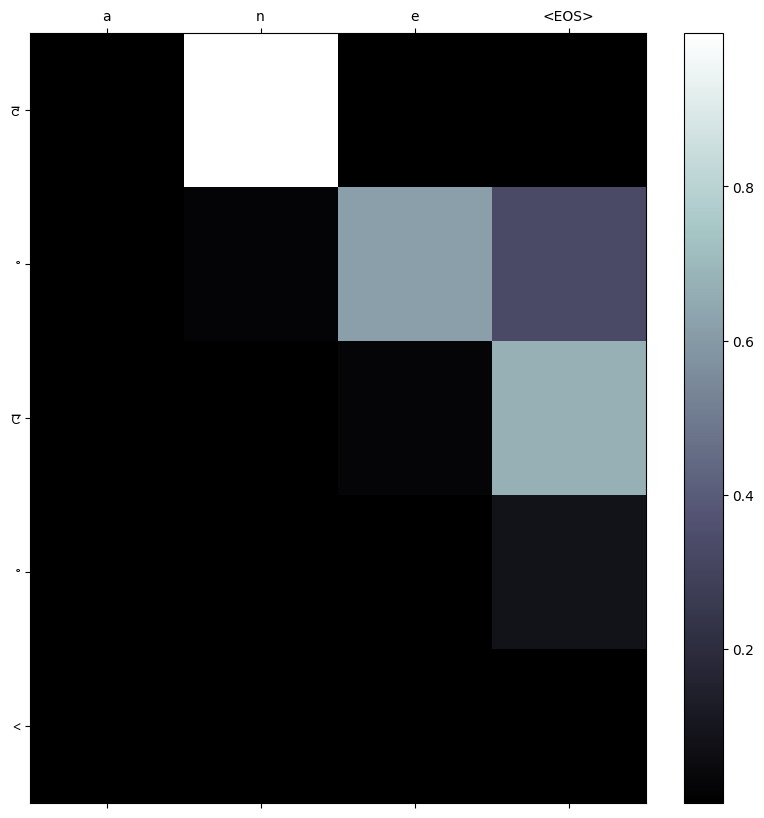

14 torch.Size([10, 30])


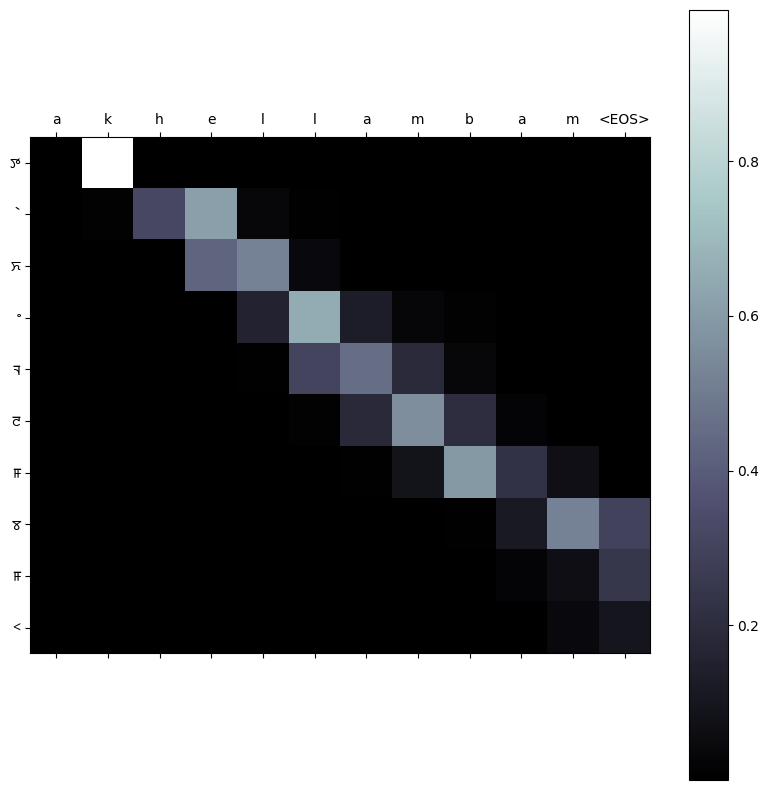

In [28]:
# Plot the attention heatmaps for 9 random pairs in a 3x3 grid

def showAttention(input_word, output_word, attentions):
    
    # Set up figure with colorbar
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(list(input_word) + ['<EOS>'])
    ax.set_yticklabels([''] + list(output_word) + ['<EOS>'], font=fpath)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # wandb.log({"attention": [wandb.Image(plt)]})

    plt.show()

def evaluateAndShowAttention(input_word):
    decoded_chars, decoder_attentions = evaluate(encoder, decoder, input_word)
    # print(len(decoded_chars), decoder_attentions.shape)
    # Use the decoded_attentions until the first <EOS> token
    decoder_attentions = decoder_attentions[:, :len(input_word)]

    showAttention(input_word, decoded_chars, decoder_attentions)

random_pairs = random.sample(test_pairs, 9)
for pair in random_pairs:
    evaluateAndShowAttention(pair[0])